In [8]:
!pip install '/kaggle/input/dlibpkg/dlib-19.19.0'

Processing /kaggle/input/dlibpkg/dlib-19.19.0
  Created wheel for dlib: filename=dlib-19.19.0-cp36-cp36m-linux_x86_64.whl size=4086380 sha256=1f368c14ca5dd30e78546574fcb0a126b5c6084ed820ae9a03d0f14007fdb48f
  Stored in directory: /root/.cache/pip/wheels/f3/da/18/38136f7dd8e242c1cc2236d574a50f34463b8c59aab887dd79
Successfully built dlib


In [9]:
import os
import json
import cv2
import dlib
import numpy as np
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

**Data Augementation**

In [10]:
train_frame_folder = '/kaggle/input/deepfake-detection-challenge/train_sample_videos'
output_real_folder = '/kaggle/working/dataset/real'
output_fake_folder = '/kaggle/working/dataset/fake'

# Create directories if they do not exist
os.makedirs(output_real_folder, exist_ok=True)
os.makedirs(output_fake_folder, exist_ok=True)

with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)

list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()

# Counters for frames and images
original_real_count = 0
original_fake_count = 0
augmented_real_count = 0
augmented_fake_count = 0

In [11]:
def augment_frame(frame):
    # Example augmentations: flipping, rotation
    augmented_frames = []
    
    # Original frame
    augmented_frames.append(frame)
    
    # Horizontal flip
    flip_frame = cv2.flip(frame, 1)
    augmented_frames.append(flip_frame)
    
    # Shift by 15 pixels to the right
    shift_M = np.float32([[1, 0, 15], [0, 1, 0]])
    shift_frame = cv2.warpAffine(frame, shift_M, (frame.shape[1], frame.shape[0]))
    augmented_frames.append(shift_frame)
    
    return augmented_frames

for vid in list_of_train_data:
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if not ret:
            break
        if frameId % ((int(frameRate) + 1) * 1) == 0:
            label = data[vid]['label']
            if label == 'REAL':
                original_real_count += 1
            elif label == 'FAKE':
                original_fake_count += 1

            augmented_frames = augment_frame(frame)
            for aug_idx, aug_frame in enumerate(augmented_frames):
                face_rects, scores, idx = detector.run(aug_frame, 0)
                for i, d in enumerate(face_rects):
                    x1 = max(0, d.left())
                    y1 = max(0, d.top())
                    x2 = min(aug_frame.shape[1], d.right())
                    y2 = min(aug_frame.shape[0], d.bottom())
                    
                    if x2 > x1 and y2 > y1:  # Ensure the rectangle is valid
                        crop_img = aug_frame[y1:y2, x1:x2]
                        if crop_img.size != 0:  # Ensure the cropped image is not empty
                            resized_img = cv2.resize(crop_img, (128, 128))
                            if label == 'REAL':
                                augmented_real_count += 1
                                output_path = os.path.join(output_real_folder, f"{vid.split('.')[0]}_{str(int(frameId))}_aug_{aug_idx}.png")
                                cv2.imwrite(output_path, resized_img)
                            elif label == 'FAKE':
                                augmented_fake_count += 1
                                output_path = os.path.join(output_fake_folder, f"{vid.split('.')[0]}_{str(int(frameId))}_aug_{aug_idx}.png")
                                cv2.imwrite(output_path, resized_img)
    cap.release()

In [12]:
# Print the number of frames before and after augmenting
print(f"Number of original REAL frames: {original_real_count}")
print(f"Number of original FAKE frames: {original_fake_count}")
print(f"Number of augmented REAL frames: {augmented_real_count}")
print(f"Number of augmented FAKE frames: {augmented_fake_count}")

Number of original REAL frames: 770
Number of original FAKE frames: 3230
Number of augmented REAL frames: 2279
Number of augmented FAKE frames: 8936


**Train-test split**

In [13]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [14]:
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

input_shape = (128, 128, 3)
data_dir = '/kaggle/working/dataset'

real_data = [f for f in os.listdir(data_dir + '/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir + '/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir + '/real/' + img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir + '/fake/' + img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

# Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

# Reshape
X = X.reshape(-1, 128, 128, 3)

# Initial Train-Test split (80% train, 20% temp)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=5)

# Further split temp into validation and test (50% each from temp, resulting in 10% each from original dataset)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

# Print dataset sizes to verify splits
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

Using TensorFlow backend.


Number of training samples: 7565
Number of validation samples: 1621
Number of test samples: 1622


**Training using InceptionResnetV2**

In [15]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [16]:
# Define the custom self-attention layer
class SelfAttention(Layer):
    def _init_(self, **kwargs):
        super(SelfAttention, self)._init_(**kwargs)

    def build(self, input_shape):
        self.query_conv = Conv2D(filters=input_shape[-1] // 8, kernel_size=1)
        self.key_conv = Conv2D(filters=input_shape[-1] // 8, kernel_size=1)
        self.value_conv = Conv2D(filters=input_shape[-1], kernel_size=1)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)

        # Compute attention scores
        attention_scores = tf.matmul(tf.reshape(query, [tf.shape(query)[0], -1, tf.shape(query)[-1]]),
                                     tf.reshape(key, [tf.shape(key)[0], -1, tf.shape(key)[-1]]),
                                     transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores)

        # Apply attention scores to value
        attention_output = tf.matmul(attention_scores,
                                     tf.reshape(value, [tf.shape(value)[0], -1, tf.shape(value)[-1]]))
        attention_output = tf.reshape(attention_output, tf.shape(inputs))

        return attention_output

# Load the MobileNet model
input_shape = (128, 128, 3)
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
mobilenet.trainable = True

# Create a Sequential model and add the MobileNet model
model = Sequential()
model.add(mobilenet)

# Add pooling and dense layers
model.add(GlobalAveragePooling2D())
model.add(Dense(units=512, activation='relu'))

# Add the remaining dense layers before the self-attention layer
model.add(Dense(units=256, activation='relu'))

# Reshape the output to 4D before adding the custom self-attention layer
model.add(Reshape((1, 1, 256)))

# Add the custom self-attention layer
model.add(SelfAttention())

# Flatten the output back to 2D
model.add(Flatten())

# Add the remaining dense layers
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
self_attention_5 (SelfAttent (None, 1, 1, 256)         82240     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

In [17]:
# Define the number of epochs
EPOCHS = 20

# Train the model for 20 epochs
history = model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=EPOCHS,
    validation_data=(X_val, Y_val),
    verbose=1
)

Train on 7565 samples, validate on 1621 samples
Epoch 1/20
7565/7565 [==============================] - 18s 2ms/sample - loss: 0.4758 - accuracy: 0.7800 - val_loss: 0.4687 - val_accuracy: 0.7909
Epoch 2/20
7565/7565 [==============================] - 11s 1ms/sample - loss: 0.3398 - accuracy: 0.8436 - val_loss: 0.3375 - val_accuracy: 0.8627
Epoch 3/20
7565/7565 [==============================] - 11s 2ms/sample - loss: 0.2268 - accuracy: 0.9140 - val_loss: 0.2076 - val_accuracy: 0.9133
Epoch 4/20
7565/7565 [==============================] - 11s 1ms/sample - loss: 0.1378 - accuracy: 0.9576 - val_loss: 0.1380 - val_accuracy: 0.9476
Epoch 5/20
7565/7565 [==============================] - 11s 1ms/sample - loss: 0.0851 - accuracy: 0.9757 - val_loss: 0.1055 - val_accuracy: 0.9587
Epoch 6/20
7565/7565 [==============================] - 11s 2ms/sample - loss: 0.0516 - accuracy: 0.9887 - val_loss: 0.0873 - val_accuracy: 0.9664
Epoch 7/20
7565/7565 [==============================] - 11s 1ms/sample

**Test Accuracy**

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# Test the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1622/1622 [==============================] - 1s 490us/sample - loss: 0.1209 - accuracy: 0.9689
Test Loss: 0.12093600630071175
Test Accuracy: 0.9688655734062195


**Plot**

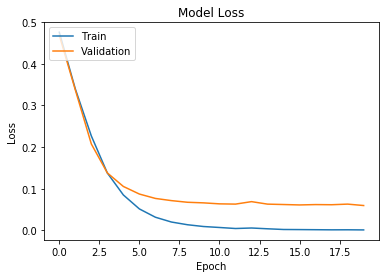

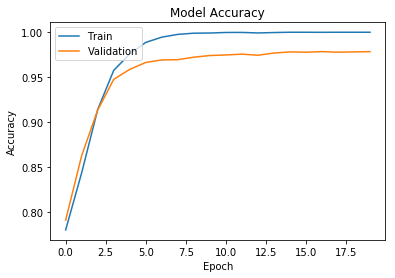

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Confusion matrix**

In [20]:
# Predict classes for test data
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1275   19]
 [  30  298]]


**Classification Report**

In [21]:
# Classification Report
class_report = classification_report(Y_true, Y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1294
           1       0.94      0.91      0.92       328

    accuracy                           0.97      1622
   macro avg       0.96      0.95      0.95      1622
weighted avg       0.97      0.97      0.97      1622

